## Import necessary libraries

In [1]:
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import awkward as ak
import dask
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema, BaseSchema
from coffea.analysis_tools import PackedSelection
import mplhep
import uproot
import coffea.nanoevents

PHYSLITESchema.warn_missing_crossrefs = False

In [2]:
from importlib.metadata import version

for package in ["numpy", "awkward", "uproot", "coffea", "dask"]:
    print(f"# {package}: v{version(package)}")

# numpy: v1.24.3
# awkward: v2.6.7
# uproot: v5.3.10
# coffea: v2024.8.0
# dask: v2023.5.0


## Use NanoEventsFactory in coffea to import root file

In [1]:
def filter_name(name):
    return name in [
        'VBFjet_maxeta', 'VBFjet_deltaeta', 'SmallRJets_pT', 'SmallRJets_eta', 'met',
        'HCand_dEtajj', 'HCand_XccScore', 'HCand_XbbScore','HCand_pT', 'HCand_Eta', 'HCand_M',
        'nonHCand_pT', 'nLargeRJets', 'nSmallRJets', 'nonHCand_Eta','passLeptonVeto', 
        'CMS_subleadJ_pT', 'CMS_leadJ_pT', 'CMS_leadJ_eta', 'CMS_subleadJ_eta', 'CMS_Mjj', 'CMS_deltaEta', 'CMScutv1', 'CMScutv2',
        'Jet1_eta', 'Jet2_eta', 'Jet1_M', 'Jet2_M', 'Jet1_pT', 'Jet2_pT', 'Mjj', 'weight'
    ]

In [4]:
samples = ["ggH","ttbar","VBF","VH","VBFH125_bb","VBFH125_cc","ttH","vjets"]
prepend_path = "/data/dliu64/Higgs_analysis/Merge_update/"

# Add QCD list
QCD_samples = []
for i in range(13):
    if i!=4:
        QCD_samples.append('QCD_%02d'%i)
for i in range(1,4):
    QCD_samples.append('QCD_04_%d'%i)
    
# Get rid of the lists that are empty
non_empty = np.array([len(uproot.open(prepend_path + sample + '.root').keys())!=0 for sample in QCD_samples])
QCD_samples = np.array(QCD_samples)[non_empty]
    
events_list = [
    NanoEventsFactory.from_root(
        {prepend_path + sample + '.root': "Nominal"},
        delayed=True,
        schemaclass=BaseSchema,
        uproot_options={"filter_name": filter_name}
    ).events()
    for sample in QCD_samples
]

In [203]:
len(events_list)

12

### Selection Rules
[WP for Hcc Tagging](https://xbb-docs.docs.cern.ch/Xbb/GN2_track/#baseline-discriminant-for-xbb-tagging-for-initial-development-in-calibration)

In [93]:
import pandas as pd
WP = np.arange(10, 70, 10)
WP.astype(str)
WP = [item+'%' for item in WP.astype(str)]
D_GN2_Hcc_cut = [4.050, 3.352, 2.810, 2.319, 1.851, 1.370]

df = pd.DataFrame({
    "Work Point": WP,
    "Cut Value on D_GN2_Hcc": D_GN2_Hcc_cut}
)
df.set_index(['Work Point', "Cut Value on D_GN2_Hcc"], inplace=True)

df

,
Work Point,Cut Value on D_GN2_Hcc
10%,4.050
20%,3.352
30%,2.810
40%,2.319
50%,1.851
60%,1.370


In [183]:
cut_result=[]
for events in events_list[:2]:
    cut_result.append(results_taskgraph(events))

print(cut_result)
for cut_results in cut_result:
    for cut, n_events in cut_results.items():
        print(f"Events passing '{cut}': {n_events}")

[{'inclusive': 23011, 'inclusive+CMScut': 795, 'inclusive+CMScut+met_upper': 718, 'inclusive+CMScut+met_lower': 176, 'inclusive+CMScut+met': 99, 'inclusive+CMScut+met+HCand_M_upper': 75, 'inclusive+CMScut+met+HCand_M_lower': 66, 'inclusive+CMScut+met+HCand_M': 42, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP10%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP20%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP30%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP40%': 1, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP50%': 1, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP60%': 3}, {'inclusive': 1508794, 'inclusive+CMScut': 34773, 'inclusive+CMScut+met_upper': 27851, 'inclusive+CMScut+met_lower': 12324, 'inclusive+CMScut+met': 5402, 'inclusive+CMScut+met+HCand_M_upper': 2128, 'inclusive+CMScut+met+HCand_M_lower': 4055, 'inclusive+CMScut+met+HCand_M': 781, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP10%': 3, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP20%': 3, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP30%':

In [71]:
Nevent=[]
for events in events_list[:3]:
    selection1 = PackedSelection()
    D_GN2_Hcc_cut = [4.050, 3.352, 2.810, 2.319, 1.851, 1.370]
    WP = np.arange(10, 70, 10)
    WP.astype(str)
    WP = [item+'%' for item in WP.astype(str)]
    
    inclusive = (events.Jet1_pT > 450) & (events.Jet1_M > 40) & (events.passLeptonVeto == True)
    cut1 = inclusive & (events.CMScutv2 == True) 
    cut2 = cut1 & (events.met < 140)
    cut3 = cut1 & (events.met > 100)
    cut4 = cut1 & (events.met < 140) & (events.met > 100)
    cut5 = cut4 & (events.HCand_M < 140)
    cut6 = cut4 & (events.HCand_M > 100)
    cut7 = cut4 & (events.HCand_M < 140) & (events.HCand_M > 100)

    cuts = [inclusive, cut1, cut2, cut3, cut4, cut5, cut6, cut7]
    #cut_name = ['inclusive', 'inclusive+CMScutv2', 'inclusive+CMScutv2+met<140', 'inclusive+CMScutv2+met<140+100<H_M', 'inclusive+CMScutv2+met<140+100<H_M<140', 'WP 50', 'WP 40', 'WP 30', 'WP 20', 'WP 10']

    selection1.add("inclusive", inclusive)
    selection1.add("inclusive+CMScut", cut1)
    selection1.add("inclusive+CMScut+met<140", cut2)
    selection1.add("inclusive+CMScut+met>100", cut3)
    selection1.add("inclusive+CMScut+100<met<140", cut4)
    selection1.add("inclusive+CMScut+100<met<140+H_M_<140", cut5)
    selection1.add("inclusive+CMScut+100<met<140+H_M>100", cut6)
    selection1.add("inclusive+CMScut+100<met<140+100<H_M<140", cut7)
    for Work_point, Hcc_Score in zip(WP, D_GN2_Hcc_cut):
        selection1.add("inclusive+CMScut+100<met<140+100<H_M<140+HCand_Xcc_WP"+Work_point, cut7 & (events.HCand_XccScore > Hcc_Score))

    Nevent.append(events.CMS_Mjj[inclusive])
    '''
    #print(selection1.names)
    #results = {}
    for cut, cut_name in zip(cuts[:], selection1.names[:]):
        plt.hist(events.CMS_Mjj[cut], bins=100, range=(0,1000), label=cut_name)
        #n_events = ak.sum(selection1.all(cut), axis=0)
        #results[cut] = n_events
    plt.xlabel('CMS_Mjj')
    plt.legend()
    #cut_results, *_ = dask.compute(results) #'''

    


In [ ]:
%%time

Nevents= dask.compute(Nevent)

In [65]:
x, y, z =  Nevents[0]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 1. 2. 1. 0. 1. 0. 0. 0. 0. 3. 2.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 3. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 2. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0.
 1. 0. 0. 0.]
[1.6906e+04 0.0000e+00 2.0000e+00 1.0000e+01 6.7000e+01 3.9000e+02
 1.6820e+03 4.5520e+03 9.6600e+03 1.5331e+04 1.9948e+04 2.3240e+04
 2.6138e+04 3.0346e+04 3.5651e+04 4.1437e+04 4.4192e+04 4.3702e+04
 4.2318e+04 3.9460e+04 3.6799e+04 3.4294e+04 3.1725e+04 2.8825e+04
 2.5636e+04 2.2568e+04 1.9709e+04 1.7763e+04 1.6109e+04 1.5077e+04
 1.3916e+04 1.3325e+04 1.2725e+04 1.2059e+04 1.1792e+04 1.1481e+04
 1.1096e+04 1.0728e+04 1.0918e+04 1.0488e+04 1.0442e+04 1.0382e+04
 1.0165e+04 1.0135e+04 9.8740e+03 9.6260e+03 9.6950e+03 9.3670e+03
 9.3640e+03 8.9730e+03 9.0340e+03 8.7800e+03 8.5470e+03 8.4230e+03
 8.3420e+03 8.0660e+03 7.9260e+03 7.6100e+03 7.2060e+03 7.2130e+03
 6.8630e+03 6.5210e+03 6

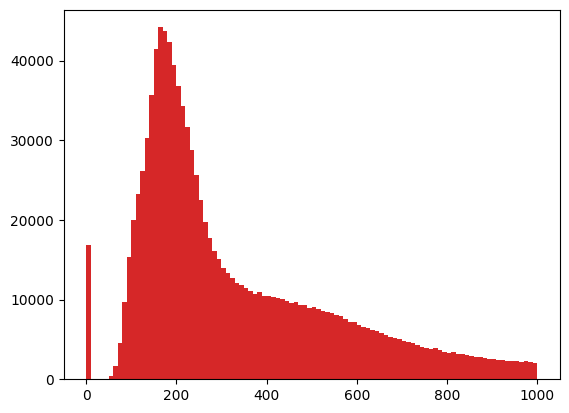

In [70]:
from hist.dask import Hist
import hist

h = Hist(hist.axis.Regular(10, 0.0, 1000, name="CMSMjj"))
mass_hist = hist.new.Reg(100, 0, 1000, name='mass', label="$m_{jj}$ [GeV]")
#mass_hist.Weight().fill(Nevents[0][0])
tot_hist = np.zeros(100)
for event in Nevents[0]:
    histo, edges, _ = plt.hist(event, bins=100, range=(0,1000))
    tot_hist += plt.hist(event, bins=100, range=(0,1000))[0]
    print(histo)
print(tot_hist)

In [174]:
for cut in selection1.names:
    for cut, cut_name in zip(cuts[:], selection1.names[:])
    n_events = ak.sum(selection1.all(cut), axis=0)
    results[cut] = n_events
cut_results, *_ = dask.compute(results)
print(cut_results)
for cut, n_events in cut_results.items():
    print(f"Events passing '{cut}': {n_events}")

{'inclusive': 23011, 'inclusive+CMScut': 795, 'inclusive+CMScut+met_upper': 718, 'inclusive+CMScut+met_lower': 176, 'inclusive+CMScut+met': 99, 'inclusive+CMScut+met+HCand_M_upper': 75, 'inclusive+CMScut+met+HCand_M_lower': 66, 'inclusive+CMScut+met+HCand_M': 42, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP10%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP20%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP30%': 0, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP40%': 1, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP50%': 1, 'inclusive+CMScut+met+HCand_M+HCand_Xcc_WP60%': 3}
Events passing 'inclusive': 23011
Events passing 'inclusive+CMScut': 795
Events passing 'inclusive+CMScut+met_upper': 718
Events passing 'inclusive+CMScut+met_lower': 176
Events passing 'inclusive+CMScut+met': 99
Events passing 'inclusive+CMScut+met+HCand_M_upper': 75
Events passing 'inclusive+CMScut+met+HCand_M_lower': 66
Events passing 'inclusive+CMScut+met+HCand_M': 42
Events passing 'inclusive+CMScut+met+HCand_M+HCand_Xcc_

In [43]:
ak.sum(selection.all('inclusive', 'CMScutv2', 'met_upper'), axis=0).compute()

718

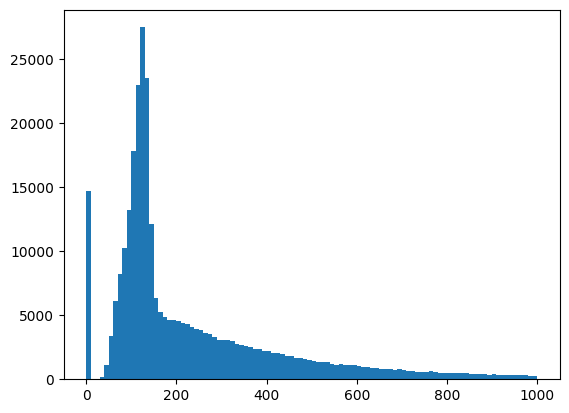

In [19]:
plv = events.passLeptonVeto.compute()
#events.CMS_Mjj[plv].compute()
CMS_mjj = events.CMS_Mjj.compute()
#ak.max(CMS_mjj)
plt.hist(CMS_mjj, bins=100, range=(0, 1000))
plt.show()

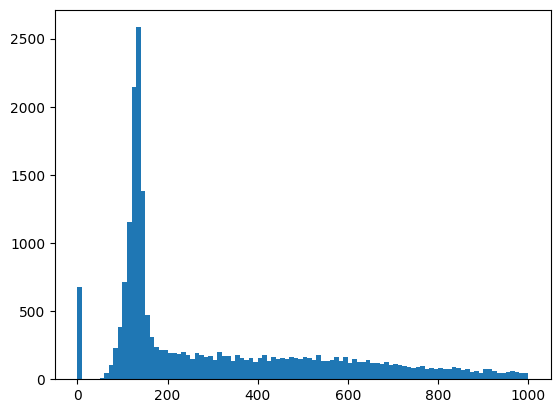

In [199]:
plt.hist(events.CMS_Mjj[inclusive].compute(), bins=100, range=(0,1000))
plt.show()

In [193]:
selection = PackedSelection()

inclusive = (events.Jet1_pT > 450) & (events.Jet1_M > 40) & (events.passLeptonVeto == True)
CMScutv2 = events.CMScutv2 == True
met_upper = events.met < 140
met_lower = events.met > 100
HCandM_upper = events.HCand_M < 140
HCandM_lower = events.HCand_M > 100
HCand_XccScore_1851 = events.HCand_XccScore > 1.851
HCand_XccScore_2319 = events.HCand_XccScore > 2.319
HCand_XccScore_2810 = events.HCand_XccScore > 2.810
HCand_XccScore_3352 = events.HCand_XccScore > 3.352
HCand_XccScore_4050 = events.HCand_XccScore > 4.050
Jet2_cut = (events.Jet2_pT > 200) & (events.Jet2_M > 40) & (events.nSmallRJets > 0)


selection.add("inclusive", inclusive)
selection.add("CMScutv2", CMScutv2)
selection.add("met_upper", met_upper)
selection.add("met_lower", met_lower)
selection.add("HCandM_upper", HCandM_upper)
selection.add("HCandM_lower", HCandM_lower)
selection.add("HCand_XccScore_1851", HCand_XccScore_1851)
selection.add("HCand_XccScore_2319", HCand_XccScore_2319)
selection.add("HCand_XccScore_2810", HCand_XccScore_2810)
selection.add("HCand_XccScore_3352", HCand_XccScore_3352)
selection.add("HCand_XccScore_4050", HCand_XccScore_4050)
print(selection.names)


['inclusive', 'CMScutv2', 'met_upper', 'met_lower', 'HCandM_upper', 'HCandM_lower', 'HCand_XccScore_1851', 'HCand_XccScore_2319', 'HCand_XccScore_2810', 'HCand_XccScore_3352', 'HCand_XccScore_4050']
